In [59]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import mplcursors
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from sqlalchemy import create_engine

from ppcollapse import setup_logger
from ppcollapse.utils.config import ConfigManager
from ppcollapse.utils.database import get_collapses_df

logger = setup_logger(level="INFO", name="ppcx")
config = ConfigManager(config_path="config.yaml")
db_engine = create_engine(config.db_url)

In [60]:
engine = create_engine(config.db_url)
df = get_collapses_df(engine)
if df.empty:
    logger.warning("No collapses found in database.")
df

,id,date,image_id,geom_wkt,area,volume
0,1502,2023-09-30,40141,MULTIPOLYGON(((2905.1149606299323 3983.4141732...,75287.49331,NaN
1,1501,2023-09-12,39963,MULTIPOLYGON(((2748.982677165365 4139.54645669...,66922.73695,NaN
2,1499,2023-09-11,39949,MULTIPOLYGON(((2663.2629921259954 3766.0535433...,72447.69367,NaN
3,1500,2023-09-11,39949,MULTIPOLYGON(((2023.4267716535542 3707.8866141...,79983.00359,NaN
4,1498,2023-09-10,39937,MULTIPOLYGON(((2069.348031496074 3557.87716535...,238168.27834,NaN
...,...,...,...,...,...,...
491,1012,2014-05-31,65275,MULTIPOLYGON(((2636.2204724409453 4228.8377952...,809189.81559,15000.0
492,1011,2014-05-27,65179,MULTIPOLYGON(((2428.0440944881893 3820.6488188...,135110.73117,NaN
493,1010,2014-05-18,64963,MULTIPOLYGON(((1662.6897637795282 3814.5259842...,165762.23923,11000.0
494,1009,2014-05-17,64938,MULTIPOLYGON(((2395.388976377953 3832.89448818...,171791.73680,NaN


In [61]:
# prepare data
df["date"] = pd.to_datetime(df["date"])
# keep only positive values for log scale and regression
mask_pos = (df["area"] > 0) & (df["volume"] > 0)
df_pos = df.loc[mask_pos].reset_index(drop=True)
if df_pos.empty:
    raise RuntimeError("No positive area/volume points available for plotting.")

In [62]:
# Filter out 2014 data
df_pos = df_pos[df_pos["date"].dt.year != 2014].reset_index(drop=True)

# Filter out 2020 data
df_pos = df_pos[df_pos["date"].dt.year != 2020].reset_index(drop=True)

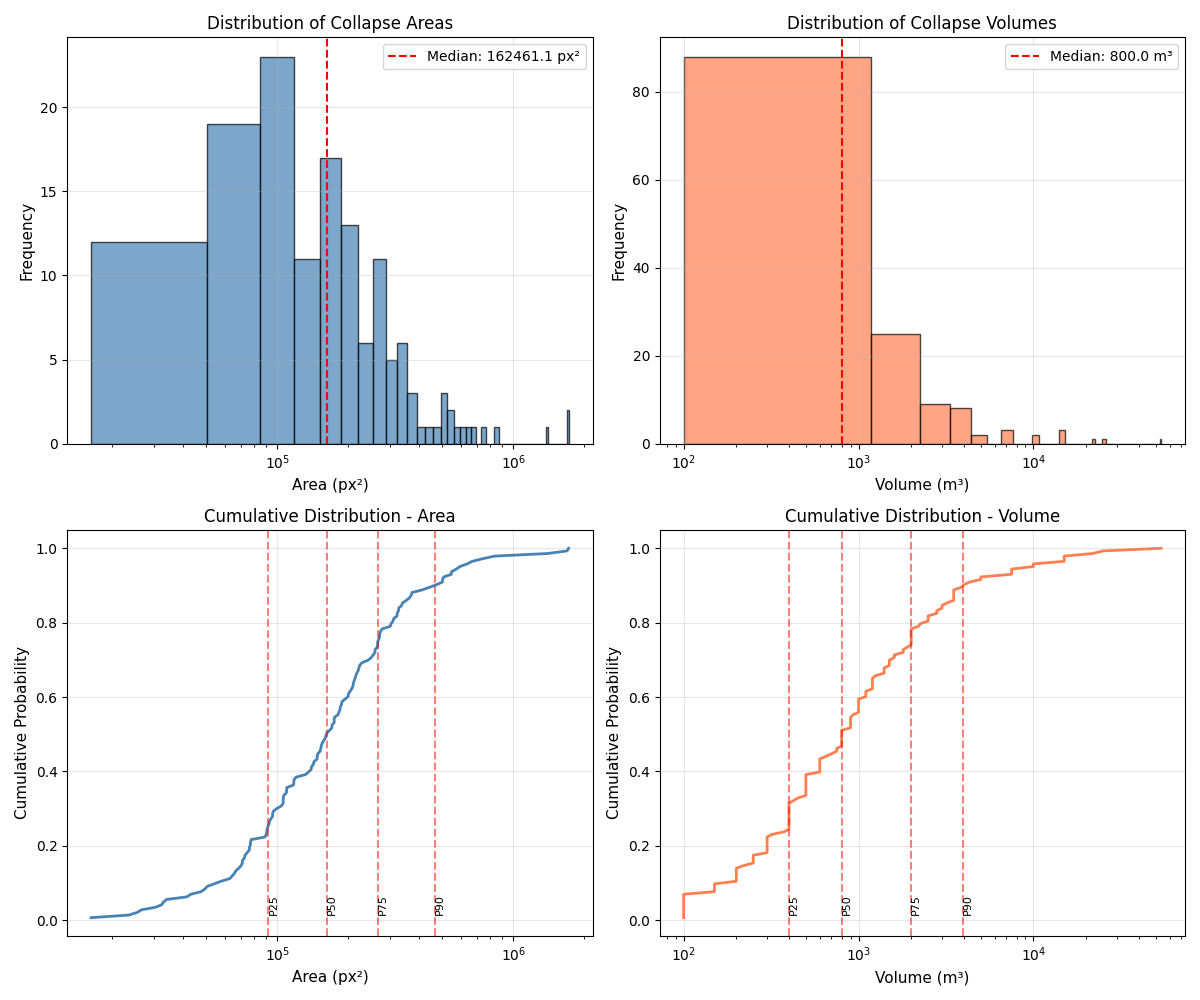


=== SUMMARY STATISTICS ===

Total collapses: 143

Area (px²):
  Min:    16307.76
  Q25:    91898.29
  Median: 162461.12
  Q75:    267938.79
  Max:    1716632.58
  Mean:   230094.84
  Std:    254485.04

Volume (m³):
  Min:    100.00
  Q25:    400.00
  Median: 800.00
  Q75:    2000.00
  Max:    53700.00
  Mean:   2352.66
  Std:    5668.80

Collapses by year:
date
2015    13
2016    34
2017    19
2018    36
2019    41

89.5% of collapses have area < 466367.8 px² (P90)


In [63]:
# Exploratory Data Analysis - Before fitting

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Histogram of Areas (log scale)
ax = axes[0, 0]
ax.hist(df_pos["area"], bins=50, edgecolor="k", alpha=0.7, color="steelblue")
ax.set_xlabel("Area (px²)", fontsize=11)
ax.set_ylabel("Frequency", fontsize=11)
ax.set_title("Distribution of Collapse Areas", fontsize=12)
ax.set_xscale("log")
ax.grid(alpha=0.3)
ax.axvline(
    df_pos["area"].median(),
    color="red",
    linestyle="--",
    label=f"Median: {df_pos['area'].median():.1f} px²",
)
ax.legend()

# 2. Histogram of Volumes (log scale)
ax = axes[0, 1]
ax.hist(df_pos["volume"], bins=50, edgecolor="k", alpha=0.7, color="coral")
ax.set_xlabel("Volume (m³)", fontsize=11)
ax.set_ylabel("Frequency", fontsize=11)
ax.set_title("Distribution of Collapse Volumes", fontsize=12)
ax.set_xscale("log")
ax.grid(alpha=0.3)
ax.axvline(
    df_pos["volume"].median(),
    color="red",
    linestyle="--",
    label=f"Median: {df_pos['volume'].median():.1f} m³",
)
ax.legend()

# 4. Cumulative distribution (Area)
ax = axes[1, 0]
sorted_areas = np.sort(df_pos["area"])
cumulative = np.arange(1, len(sorted_areas) + 1) / len(sorted_areas)
ax.plot(sorted_areas, cumulative, linewidth=2, color="steelblue")
ax.set_xlabel("Area (px²)", fontsize=11)
ax.set_ylabel("Cumulative Probability", fontsize=11)
ax.set_title("Cumulative Distribution - Area", fontsize=12)
ax.set_xscale("log")
ax.grid(alpha=0.3)
# Mark percentiles
for p in [25, 50, 75, 90]:
    val = np.percentile(df_pos["area"], p)
    ax.axvline(val, color="red", linestyle="--", alpha=0.5)
    ax.text(val, 0.02, f"P{p}", rotation=90, fontsize=8)

# 5. Cumulative distribution (Volume)
ax = axes[1, 1]
sorted_volumes = np.sort(df_pos["volume"])
cumulative = np.arange(1, len(sorted_volumes) + 1) / len(sorted_volumes)
ax.plot(sorted_volumes, cumulative, linewidth=2, color="coral")
ax.set_xlabel("Volume (m³)", fontsize=11)
ax.set_ylabel("Cumulative Probability", fontsize=11)
ax.set_title("Cumulative Distribution - Volume", fontsize=12)
ax.set_xscale("log")
ax.grid(alpha=0.3)
# Mark percentiles
for p in [25, 50, 75, 90]:
    val = np.percentile(df_pos["volume"], p)
    ax.axvline(val, color="red", linestyle="--", alpha=0.5)
    ax.text(val, 0.02, f"P{p}", rotation=90, fontsize=8)

plt.tight_layout()
plt.savefig("output/collapses_exploration.png", dpi=200, bbox_inches="tight")
plt.show()

print("\n=== SUMMARY STATISTICS ===")
print(f"\nTotal collapses: {len(df_pos)}")
print("\nArea (px²):")
print(f"  Min:    {df_pos['area'].min():.2f}")
print(f"  Q25:    {df_pos['area'].quantile(0.25):.2f}")
print(f"  Median: {df_pos['area'].median():.2f}")
print(f"  Q75:    {df_pos['area'].quantile(0.75):.2f}")
print(f"  Max:    {df_pos['area'].max():.2f}")
print(f"  Mean:   {df_pos['area'].mean():.2f}")
print(f"  Std:    {df_pos['area'].std():.2f}")

print("\nVolume (m³):")
print(f"  Min:    {df_pos['volume'].min():.2f}")
print(f"  Q25:    {df_pos['volume'].quantile(0.25):.2f}")
print(f"  Median: {df_pos['volume'].median():.2f}")
print(f"  Q75:    {df_pos['volume'].quantile(0.75):.2f}")
print(f"  Max:    {df_pos['volume'].max():.2f}")
print(f"  Mean:   {df_pos['volume'].mean():.2f}")
print(f"  Std:    {df_pos['volume'].std():.2f}")

print("\nCollapses by year:")
print(df_pos.groupby(df_pos["date"].dt.year).size().to_string())

# Calculate data concentration
area_p90 = df_pos["area"].quantile(0.90)
pct_below_p90 = (df_pos["area"] < area_p90).sum() / len(df_pos) * 100
print(f"\n{pct_below_p90:.1f}% of collapses have area < {area_p90:.1f} px² (P90)")


In [64]:
from sklearn.linear_model import HuberRegressor

fit_powerlaw = True  # Fit power-law (log-log) or linear (lin-lin)
stratified_sampling = True  # Stratified sampling to reduce bias toward small collapses

if stratified_sampling:
    # Log-binning approach (better for power-law distributions)
    # Group data into logarithmic bins and subsample evenly

    # Create log-bins for area
    n_bins = 10
    area_bins = np.logspace(
        np.log10(df_pos["volume"].min()), np.log10(df_pos["volume"].max()), n_bins + 1
    )

    # Assign each point to a bin
    df_pos["volume_bin"] = pd.cut(df_pos["volume"], bins=area_bins, labels=False)

    # Sample evenly from each bin (e.g., max 20 points per bin)
    max_per_bin = 20
    df_filtered = (
        df_pos.groupby("volume_bin", group_keys=False)
        .apply(lambda x: x.sample(n=min(len(x), max_per_bin), random_state=42))
        .reset_index(drop=True)
    )
    print(f"Original data: {len(df_pos)} points")
    print(f"Log-binned filtered data: {len(df_filtered)} points")
    print(f"Points per bin: {df_filtered['volume_bin'].value_counts().sort_index()}")
else:
    df_filtered = df_pos.copy()

if fit_powerlaw:
    # fit a power-law using robust regression: log(vol)=a*log(area)+b
    logA = np.log10(df_filtered["area"].astype(float)).values.reshape(-1, 1)
    logV = np.log10(df_filtered["volume"].astype(float)).values

    # Huber regression (robust to outliers)
    huber = HuberRegressor(epsilon=1.35, max_iter=100)
    huber.fit(logA, logV)
    a = huber.coef_[0]
    b = huber.intercept_

    # calculate R²
    pred_logV = huber.predict(logA)
    ss_tot = np.sum((logV - logV.mean()) ** 2)
    ss_res = np.sum((logV - pred_logV) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    print(f"Huber regression: a={a:.3f}, b={b:.3f}, R²={r2:.3f}")

else:
    # Fit linear regression: vol=a*area+b
    from sklearn.linear_model import HuberRegressor

    A = df_filtered["area"].astype(float).values.reshape(-1, 1)
    V = df_filtered["volume"].astype(float).values
    huber = HuberRegressor(epsilon=1.35, max_iter=100)
    huber.fit(A, V)
    a = huber.coef_[0]
    b = huber.intercept_
    # calculate R²
    pred_V = huber.predict(A)
    ss_tot = np.sum((V - V.mean()) ** 2)
    ss_res = np.sum((V - pred_V) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    print(f"Huber regression: a={a:.3f}, b={b:.3f}, R²={r2:.3f}")

Original data: 143 points
Log-binned filtered data: 112 points
Points per bin: volume_bin
0.0     4
1.0    19
2.0    20
3.0    20
4.0    20
5.0    16
6.0     5
7.0     5
8.0     2
9.0     1
Name: count, dtype: int64
Huber regression: a=1.218, b=-3.363, R²=0.633


/tmp/ipykernel_84014/3675094470.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), max_per_bin), random_state=42))


/tmp/ipykernel_84014/604900600.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(9, 6))


Saved plot to output/collapses_area_volume_linear.png


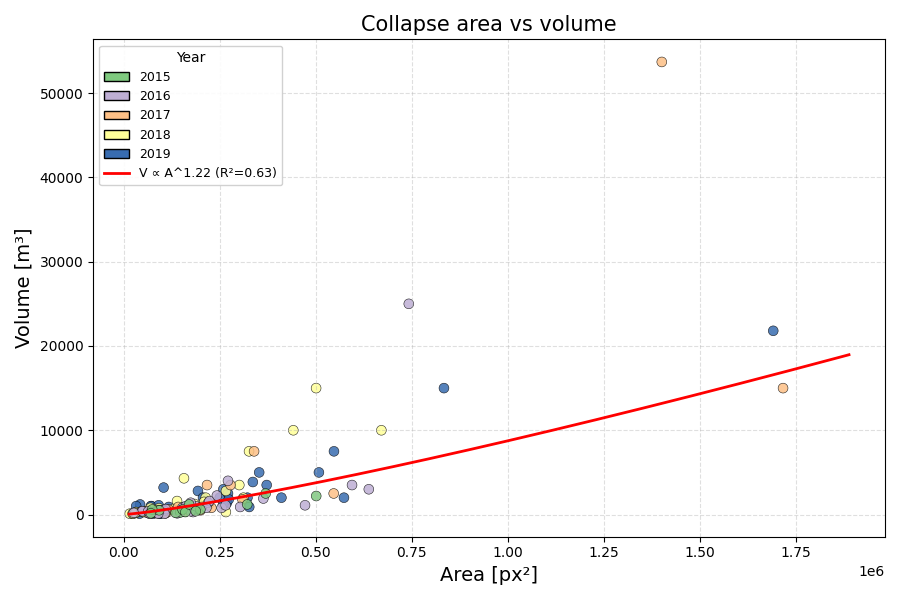

In [65]:
# Make area-volume plots for all collapses in the DB - Linear scale
fig, ax = plt.subplots(figsize=(9, 6))
colormap = "Accent"
min_size, max_size = 2, 150

# Extract year from date and create discrete color mapping
df_pos["year"] = df_pos["date"].dt.year
unique_years = sorted(df_pos["year"].unique())
n_years = len(unique_years)
cmap = plt.get_cmap(colormap)
year_to_color = {year: cmap(i) for i, year in enumerate(unique_years)}
colors = [year_to_color[year] for year in df_pos["year"]]

# marker size from area (scaled)
# sizes_norm = plt.Normalize(
#     np.sqrt(df_pos["volume"].astype(float)).min(),
#     np.sqrt(df_pos["volume"].astype(float)).max(),
# )
# sizes = min_size + (max_size - min_size) * sizes_norm(
#     np.sqrt(df_pos["volume"].astype(float))
# )
sizes = 50

# plot
sc = ax.scatter(
    df_pos["area"],
    df_pos["volume"],
    c=colors,
    s=sizes,
    alpha=0.85,
    edgecolor="k",
    linewidth=0.4,
)

ax.set_xlabel("Area [px²]", fontsize=14)
ax.set_ylabel("Volume [m³]", fontsize=14)

# Overlay the power-law fit in linear scale
area_range = np.linspace(
    df_pos["area"].min() - 0.1 * df_pos["area"].min(),
    df_pos["area"].max() + 0.1 * df_pos["area"].max(),
    200,
)
if fit_powerlaw:
    vol_pred = 10 ** (a * np.log10(area_range) + b)
else:
    vol_pred = a * area_range + b
ax.plot(
    area_range,
    vol_pred,
    color="red",
    lw=2,
    label=f"fit: V = {a:.2f}·A + {b:.2f} (R²={r2:.2f})",
)

ax.set_title("Collapse area vs volume", fontsize=15)

# Create custom legend for years
legend_elements = [
    Patch(facecolor=year_to_color[year], edgecolor="k", label=str(year))
    for year in unique_years
]
# Add fit line to legend
if fit_powerlaw:
    legend_elements.append(
        plt.Line2D([0], [0], color="red", lw=2, label=f"V ∝ A^{a:.2f} (R²={r2:.2f})")
    )
else:
    legend_elements.append(
        plt.Line2D(
            [0], [0], color="red", lw=2, label=f"V = {a:.2f}·A + {b:.2f} (R²={r2:.2f})"
        )
    )
ax.legend(
    handles=legend_elements, loc="upper left", fontsize=9, title="Year", framealpha=0.9
)

cursor = mplcursors.cursor(sc, hover=True)


@cursor.connect("add")
def on_add(sel):
    idx = sel.index
    row = df_pos.iloc[idx]
    sel.annotation.set(
        text=(
            f"ID: {row['id']}\n"
            f"Date: {row['date'].date()}\n"
            f"Area: {row['area']:.1f} m²\n"
            f"Volume: {row['volume']:.1f} m³"
        ),
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
    )


ax.grid(which="both", linestyle="--", alpha=0.4)
fig.tight_layout()

out_path = "output/collapses_area_volume_linear.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
print(f"Saved plot to {out_path}")


/tmp/ipykernel_84014/2523496259.py:5: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date_nums = mdates.date2num(df_pos["date"].dt.to_pydatetime())


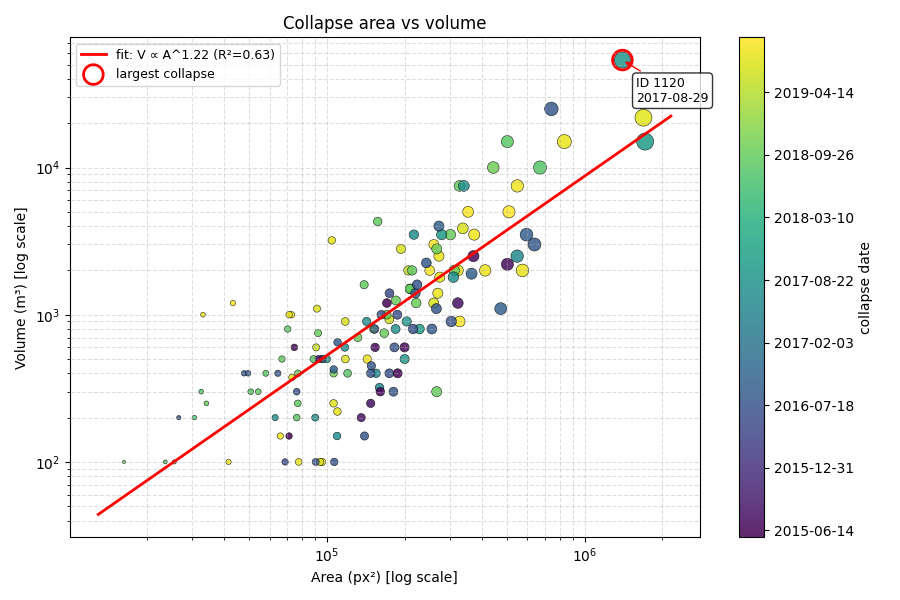

In [66]:
# Make a Log-Log plot with regression
fig, ax = plt.subplots(figsize=(9, 6))

# color by date (older -> darker)
date_nums = mdates.date2num(df_pos["date"].dt.to_pydatetime())
norm = plt.Normalize(date_nums.min(), date_nums.max())
cmap = plt.get_cmap("viridis")

# marker size from area (scaled)
sizes_norm = plt.Normalize(
    np.sqrt(df_pos["area"].astype(float)).min(),
    np.sqrt(df_pos["area"].astype(float)).max(),
)
min_size, max_size = 5, 150
sizes = min_size + (max_size - min_size) * sizes_norm(
    np.sqrt(df_pos["area"].astype(float))
)

# scatter
sc = ax.scatter(
    df_pos["area"],
    df_pos["volume"],
    c=date_nums,
    cmap=cmap,
    norm=norm,
    s=sizes,
    alpha=0.85,
    edgecolor="k",
    linewidth=0.4,
)

# regression line in original space
area_range = np.logspace(
    np.log10(df_pos["area"].min()) - 0.1, np.log10(df_pos["area"].max()) + 0.1, 200
)
vol_pred = 10 ** (a * np.log10(area_range) + b)
ax.plot(
    area_range, vol_pred, color="red", lw=2, label=f"fit: V ∝ A^{a:.2f} (R²={r2:.2f})"
)

# highlight largest collapse by volume
idx_max = df_pos["volume"].idxmax()
ax.scatter(
    [df_pos.loc[idx_max, "area"]],
    [df_pos.loc[idx_max, "volume"]],
    s=200,
    facecolor="none",
    edgecolor="red",
    linewidth=2,
    label="largest collapse",
)
ax.annotate(
    f"ID {int(df_pos.loc[idx_max, 'id'])}\n{df_pos.loc[idx_max, 'date'].date()}",
    xy=(df_pos.loc[idx_max, "area"], df_pos.loc[idx_max, "volume"]),
    xytext=(10, -30),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", color="red"),
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Area (px²) [log scale]")
ax.set_ylabel("Volume (m³) [log scale]")
ax.set_title("Collapse area vs volume")

# colorbar for date
cbar = fig.colorbar(sc, ax=ax)
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
cbar.set_label("collapse date")

ax.grid(which="both", linestyle="--", alpha=0.4)
ax.legend(loc="upper left", fontsize=9)
fig.tight_layout()

out_path = "output/collapses_area_volume_loglog.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")

In [70]:
# Write a text file with all the collapses date
min_collapse_area = 150000  # px²
df_out = df_pos[df_pos["area"] >= min_collapse_area].sort_values(by="date")
with open("output/collapses_dates.csv", "w") as f:
    f.write("Date,Collapse_ID,Area,Volume\n")
    for _, row in df_out.iterrows():
        f.write(f"{row['date'].date()},{row['id']},{row['area']},{row['volume']}\n")